# Hit Song Predictor: A Logistic Regression Approach

## Project Overview
This project uses logistic regression to predict whether a song will be a 'hit' based on audio features like danceability, energy, valence, and tempo. The model analyzes patterns in successful tracks to identify what makes a song popular.

**Key Skills Demonstrated:**
- Binary classification with logistic regression
- Feature engineering and selection
- Handling imbalanced datasets
- Model evaluation and interpretation
- Data visualization for music analytics

### Import Necessary Tools & Libraries

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

### Load the Dataset

In [96]:
df = pd.read_csv("songs_normalize.csv")

### Inspect Data

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist            2000 non-null   object 
 1   song              2000 non-null   object 
 2   duration_ms       2000 non-null   int64  
 3   explicit          2000 non-null   bool   
 4   year              2000 non-null   int64  
 5   popularity        2000 non-null   int64  
 6   danceability      2000 non-null   float64
 7   energy            2000 non-null   float64
 8   key               2000 non-null   int64  
 9   loudness          2000 non-null   float64
 10  mode              2000 non-null   int64  
 11  speechiness       2000 non-null   float64
 12  acousticness      2000 non-null   float64
 13  instrumentalness  2000 non-null   float64
 14  liveness          2000 non-null   float64
 15  valence           2000 non-null   float64
 16  tempo             2000 non-null   float64


In [98]:
df.head()

,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,Britney Spears,Oops!...I Did It Again,211160,False,2000,77,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,pop
1,blink-182,All The Small Things,167066,False,1999,79,0.434,0.897,0,-4.918,1,0.0488,0.0103,0.000000,0.6120,0.684,148.726,"rock, pop"
2,Faith Hill,Breathe,250546,False,1999,66,0.529,0.496,7,-9.007,1,0.0290,0.1730,0.000000,0.2510,0.278,136.859,"pop, country"
3,Bon Jovi,It's My Life,224493,False,2000,78,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.3470,0.544,119.992,"rock, metal"
4,*NSYNC,Bye Bye Bye,200560,False,2000,65,0.614,0.928,8,-4.806,0,0.0516,0.0408,0.001040,0.0845,0.879,172.656,pop


### Exploratory Data Analysis

In [99]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())
print("\nData Types:")
print(df.dtypes)
print("\nBasic Statistics:")
df.describe()

Missing Values:
artist              0
song                0
duration_ms         0
explicit            0
year                0
popularity          0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
genre               0
dtype: int64

Data Types:
artist               object
song                 object
duration_ms           int64
explicit               bool
year                  int64
popularity            int64
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
genre                object
dtype: object

Basic Statistics:


,duration_ms,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,228748.124500,2009.49400,59.872500,0.667438,0.720366,5.378000,-5.512434,0.553500,0.103568,0.128955,0.015226,0.181216,0.551690,120.122558
std,39136.569008,5.85996,21.335577,0.140416,0.152745,3.615059,1.933482,0.497254,0.096159,0.173346,0.087771,0.140669,0.220864,26.967112
min,113000.000000,1998.00000,0.000000,0.129000,0.054900,0.000000,-20.514000,0.000000,0.023200,0.000019,0.000000,0.021500,0.038100,60.019000
25%,203580.000000,2004.00000,56.000000,0.581000,0.622000,2.000000,-6.490250,0.000000,0.039600,0.014000,0.000000,0.088100,0.386750,98.985750
50%,223279.500000,2010.00000,65.500000,0.676000,0.736000,6.000000,-5.285000,1.000000,0.059850,0.055700,0.000000,0.124000,0.557500,120.021500
75%,248133.000000,2015.00000,73.000000,0.764000,0.839000,8.000000,-4.167750,1.000000,0.129000,0.176250,0.000068,0.241000,0.730000,134.265500
max,484146.000000,2020.00000,89.000000,0.975000,0.999000,11.000000,-0.276000,1.000000,0.576000,0.976000,0.985000,0.853000,0.973000,210.851000


In [100]:
# Define what makes a 'hit' - songs with popularity > 70
# Adjust this threshold based on dataset
popularity_threshold = df['popularity'].quantile(0.75)
df['is_a_hit'] = (df['popularity'] > popularity_threshold).astype(int)

print(f"Popularity threshold for 'hit': {popularity_threshold}")
print(f"\nClass distribution:")
print(df['is_a_hit'].value_counts())
print(f"\nHit rate: {df['is_a_hit'].mean():.2%}")

Popularity threshold for 'hit': 73.0

Class distribution:
is_a_hit
0    1517
1     483
Name: count, dtype: int64

Hit rate: 24.15%


### Visualize audio feature distributions for hits vs non-hits

#### The Visualization shows
Expected Strong Features:

- Danceability ⭐⭐⭐
- Energy ⭐⭐⭐
- Valence ⭐⭐

Expected Weak Features:

- Tempo, Acousticness, Instrumentalness, Liveness, Speechiness, and Loudness

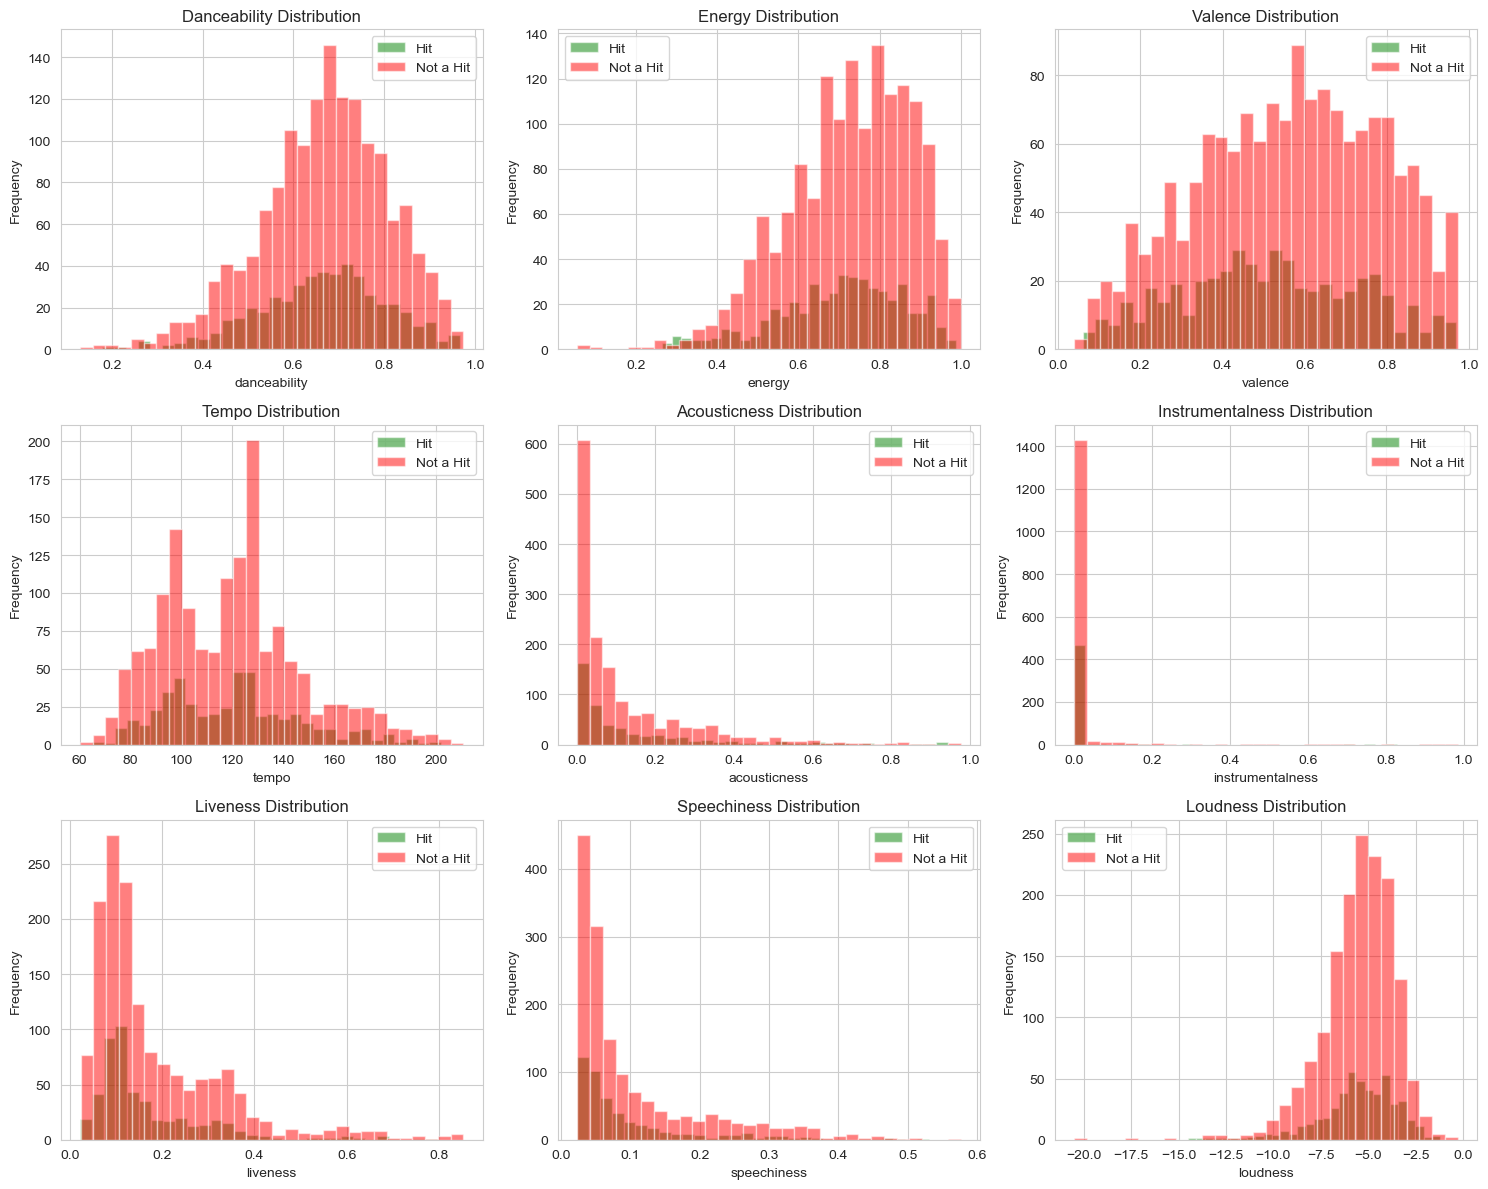

In [101]:
audio_features = ['danceability', 'energy', 'valence', 'tempo', 'acousticness', 
                  'instrumentalness', 'liveness', 'speechiness', 'loudness']

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, feature in enumerate(audio_features):
    axes[idx].hist(df[df['is_a_hit']==1][feature], alpha=0.5, label='Hit', bins=30, color='green')
    axes[idx].hist(df[df['is_a_hit']==0][feature], alpha=0.5, label='Not a Hit', bins=30, color='red')
    axes[idx].set_title(f'{feature.capitalize()} Distribution')
    axes[idx].legend()
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

### Correlation heatmap

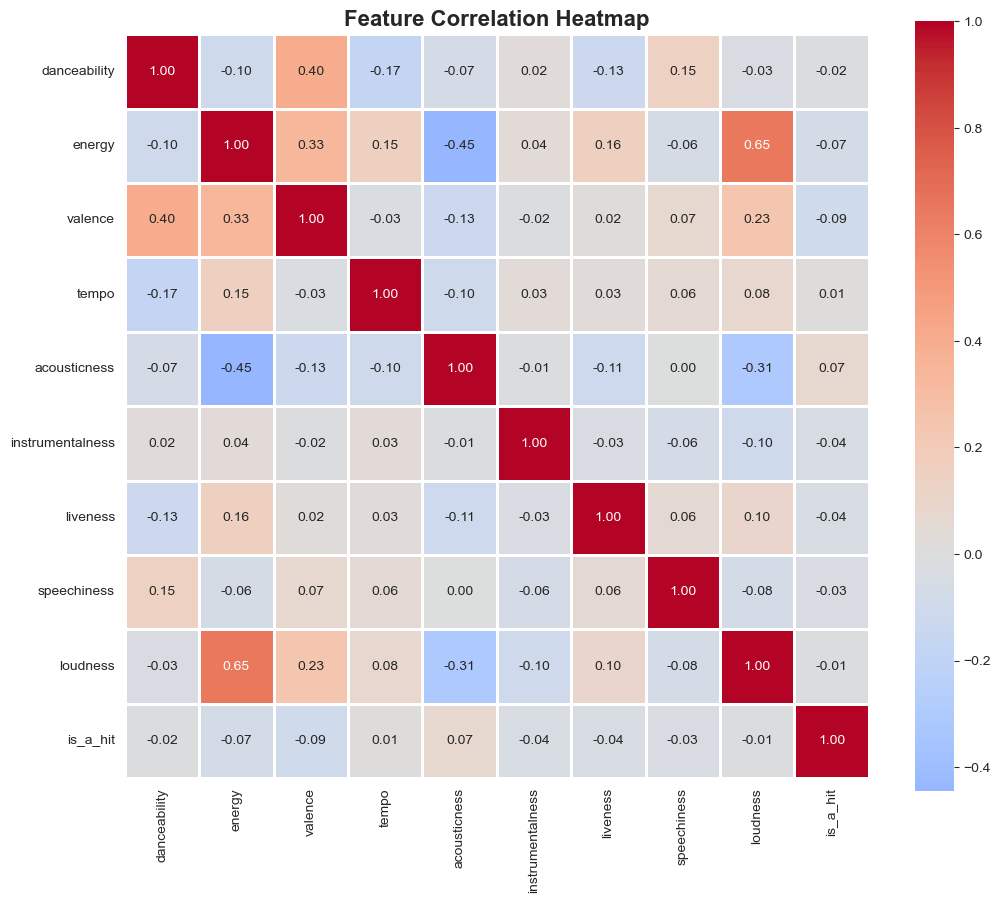

In [102]:
plt.figure(figsize=(12, 10))
correlation_matrix = df[audio_features + ['is_a_hit']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', square=True, linewidths=1)
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold')
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## Correlation Analysis

The correlation heatmap reveals an that no individual audio feature shows string correlation with hit status (as expected since music is subjective, and there are many factors that go into having a hit, such as marketing, artist's popularity, timing, and cultureal context). The strongest correlations are:

- Danceability: -0.02
- Energy: -0.07  
- Valence: -0.09
- Acousticness: 0.07
- All other features: ≈ 0.00

### My Solution: Feature Engineering

Since individual features lack predictive power, I will create interaction features that combine multiple attributes:

1. **Energy × Danceability**: Captures the "party factor" - songs that are both energetic & danceable
2. **Valence × Energy**: Represents upbeat, positive vibes
3. **Mood Score**: Average of valence and energy for overall emotional tone
4. **Normalized Tempo**: Standardized BPM for better model scaling

**Hypothesis**: These engineered features will capture the non-linear relationships and feature combinations that differentiate hits from non-hits, where individual features alone cannot.

### Feature Engineering

In [103]:
df['energy_danceability'] = df['energy'] * df['danceability']
df['valence_energy'] = df['valence'] * df['energy']

# Normalize tempo (convert BPM to a 0-1 scale)
df['tempo_normalized'] = (df['tempo'] - df['tempo'].min()) / (df['tempo'].max() - df['tempo'].min())

# Create a 'mood' feature combining valence and energy
df['mood_score'] = (df['valence'] + df['energy']) / 2

### Data Selection

In [104]:
# Select features for modeling
feature_columns = ['danceability', 'energy', 'valence', 'tempo_normalized', 
                   'acousticness', 'instrumentalness', 'liveness', 'speechiness', 
                   'loudness', 'energy_danceability', 'valence_energy', 'mood_score']

X = df[feature_columns]
y = df['is_a_hit']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                      random_state=42, stratify=y)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"\nTraining set class distribution:")
print(y_train.value_counts(normalize=True))

Training set size: (1600, 12)
Test set size: (400, 12)

Training set class distribution:
is_a_hit
0    0.75875
1    0.24125
Name: proportion, dtype: float64


### Standardizing Features for Logistic Regression

In [105]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier interpretation
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_columns)

### Train Model (Baseline)

In [106]:
baseline_model = LogisticRegression(random_state=42, max_iter=1000)
baseline_model.fit(X_train_scaled, y_train)

baseline_score = baseline_model.score(X_test_scaled, y_test)
print(f"Baseline Model Accuracy: {baseline_score:.4f}")

Baseline Model Accuracy: 0.7550


### Hyperparameter Training

In [107]:
# Using GridSearchCV (Test all possible combinations of settings and pick the best one)
param_grid = {
    # How much the model will trust the data: 
        # 0.001 [Don't Trust data too much] 
        # 100   [Trust the data and get every detail]
    'C': [0.001, 0.01, 0.1, 1, 10, 100], 

    # How to simplify the model:
        # L1: turn off uselss features completely
        # L2: Make all features contribute a little bit 
    'penalty': ['l1', 'l2'], 

    #Which algorithm trains the model?
        # liblinear: Fast and good for smaller datasets
        # saga: Better for larger datasets
    'solver': ['liblinear', 'saga'],

    #Fix the imbalance problem
        # None: Treat hits and non-hits equally
        # 'balanced': Force the model to care about hits
    'class_weight': [None, 'balanced']
}
# Test the best combo of settings
grid_search = GridSearchCV(LogisticRegression(random_state=42, max_iter=2000),
                           param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation ROC-AUC score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters: {'C': 1, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation ROC-AUC score: 0.5942
